# Setup

In [2]:
!pip install ultralytics boto3

In [1]:
from ultralytics import YOLO
import boto3
import botocore

ModuleNotFoundError: No module named 'ultralytics'

In [4]:
from os import listdir
from os.path import isfile, join
import sys
import os
from PIL import Image, ImageOps
import shutil
import numpy as np
import yaml
import argparse
from concurrent import futures
import os
import re
import sys
import tqdm
import random as rnd

In [5]:
import albumentations as A


# Data preparation

In [6]:
classes = ["Ci", "Cs", "Cc", "Ac", "As", "Cu", "Cb", "Ns", "Sc", "St", "Ct"]

In [ ]:
!unzip /content/no_night_CCSN.zip -d /content/no_night_ccsn

Archive:  /content/no_night_CCSN.zip
warning [/content/no_night_CCSN.zip]:  7857195 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  7857195
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
!unzip CCSN.zip -d /content/ccsn

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N016.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N016.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N200.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N200.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N214.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N214.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N228.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N228.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N298.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N298.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N273.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N273.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N267.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N267.jpg  
  inflating: /content/ccsn/CCSN_v2/Sc/Sc-N071.jpg  
  inflating: /content/ccsn/__MACOSX/CCSN_v2/Sc/._Sc-N071.jpg  
  inflating: /c

In [10]:
!unzip no_night_CCSN.zip -d /content/nn_ccsn

Archive:  no_night_CCSN.zip
   creating: /content/nn_ccsn/no_night_CCSN/Ac/
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N001.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N002.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N003.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N004.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N005.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N006.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N007.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N008.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N009.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N010.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N011.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N012.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N013.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N014.jpg  
  inflating: /content/nn_ccsn/no_night_CCSN/Ac/Ac-N015.jpg  
  inflati

In [7]:
def split_data(dataset_dir: str) -> dict[dict[str, list[str]]]:
  splits = {"train": {}, "test": {}, "val": {}}
  sets = {"train": 0.9, "test": 0.05, "val": 0.05}

  for _cls in classes:
    splits["train"].update({_cls: []})
    splits["test"].update({_cls: []})
    splits["val"].update({_cls: []})

    class_path = os.path.join(dataset_dir, _cls)
    images = [join(class_path, f) for f in listdir(class_path) if isfile(join(class_path, f))]
    sets_nums = {k: round(item * len(images)) for k, item in sets.items()}

    nums_sum = sum(list(sets_nums.values()))

    print(f"Images in class {_cls} are distributed as follows: train={sets_nums['train']}, test={sets_nums['test']}, val={sets_nums['val']}, total={nums_sum}. There are {len(images)} images. Any excess images will de added to the val subset")
    print("-"*80)

    for idx, img in enumerate(images):
      if idx <= sets_nums["train"]:
        splits["train"][_cls].append(img)

      elif idx <= sets_nums["train"] + sets_nums["test"]:
        splits["test"][_cls].append(img)

      else:
        splits["val"][_cls].append(img)

  return splits

In [8]:
def save_data(save_directory: str, path_to_dataset: str) -> None:
  shutil.rmtree(save_directory, ignore_errors=True)

  splits = split_data(path_to_dataset)

  for split, data in splits.items():
        print(f'Saving {split} set')
        print("-"*80)
        split_path = os.path.join(save_directory, split)
        os.makedirs(split_path)

        for _class, images in data.items():
          class_path = os.path.join(split_path, _class)
          os.makedirs(class_path)

          for i in range(len(images)):
            image_path = os.path.join(class_path, f'{i}.png')
            image = Image.open(images[i])
            image.save(image_path)

In [9]:
def save_data_to_greyscale(save_directory: str, path_to_dataset: str) -> None:
  shutil.rmtree(save_directory, ignore_errors=True)

  splits = split_data(path_to_dataset)

  for split, data in splits.items():
        print(f'Saving {split} set')
        print("-"*80)
        split_path = os.path.join(save_directory, split)
        os.makedirs(split_path)

        for _class, images in data.items():
          class_path = os.path.join(split_path, _class)
          os.makedirs(class_path)

          for i in range(len(images)):
            image_path = os.path.join(class_path, f'{i}.png')
            image = Image.open(images[i])
            image = ImageOps.grayscale(image)
            image.save(image_path)

In [10]:
def parse_data_with_oversampling(save_directory: str, path_to_dataset: str, oversampling_threshold: float = 0.5) -> None:
  shutil.rmtree(save_directory, ignore_errors=True)

  splits = split_data(path_to_dataset)

  oversampled_images = 0

  assert oversampling_threshold <= 1, "Oversampling threshold has to be in <0,1> range"
  transformer = A.ReplayCompose([
      A.HorizontalFlip(always_apply=False, p=oversampling_threshold),
      A.RandomBrightnessContrast(always_apply=False, p=oversampling_threshold / 3,
                                 brightness_limit=(-0.3, 0.3),
                                 contrast_limit=(-0.3, 0.3),
                                 brightness_by_max=False), #might not be ideal for photos of the sky
  ])

  for split, data in splits.items():
        print(f'Saving {split} set')
        print("-"*80)
        split_path = os.path.join(save_directory, split)
        os.makedirs(split_path)

        for _class, images in data.items():
          class_path = os.path.join(split_path, _class)
          os.makedirs(class_path)

          for i in range(len(images)):
            image_path = os.path.join(class_path, f'{i}.png')
            image = Image.open(images[i])
            image.save(image_path)

            if split == "train":
              oversampled_path = os.path.join(class_path, f'{i}_os.png')
              transformed = transformer(image=np.array(image))

              if transformed["replay"]["transforms"][0]["applied"] or transformed["replay"]["transforms"][0]["applied"]:
                transformed_image = Image.fromarray(transformed['image'])
                transformed_image.save(oversampled_path)
                oversampled_images += 1

  print(f"Saving completed. Oversampled {oversampled_images} images")

In [ ]:
parsed_data_path = "/content/prepared_dataset"

In [ ]:
save_data(parsed_data_path, "/content/no_night_ccsn")

In [ ]:
save_data(parsed_data_path, "/content/ccsn/CCSN_v2")

Images in class Ci are distributed as follows: train=125, test=7, val=7, total=139. There are 139 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cs are distributed as follows: train=258, test=14, val=14, total=286. There are 287 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cc are distributed as follows: train=241, test=13, val=13, total=267. There are 268 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Ac are distributed as follows: train=199, test=11, val=11, total=221. There are 221 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class As are distributed as follows:

In [ ]:
parse_data_with_oversampling(parsed_data_path, "/content/ccsn/CCSN_v2", oversampling_threshold=0.8)

Images in class Ci are distributed as follows: train=125, test=7, val=7, total=139. There are 139 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cs are distributed as follows: train=258, test=14, val=14, total=286. There are 287 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cc are distributed as follows: train=241, test=13, val=13, total=267. There are 268 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Ac are distributed as follows: train=199, test=11, val=11, total=221. There are 221 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class As are distributed as follows:

In [32]:
save_data_to_greyscale("/content/greyscale_CCSN", "/content/nn_ccsn/no_night_CCSN")

Images in class Ci are distributed as follows: train=125, test=7, val=7, total=139. There are 139 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cs are distributed as follows: train=253, test=14, val=14, total=281. There are 281 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Cc are distributed as follows: train=230, test=13, val=13, total=256. There are 256 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class Ac are distributed as follows: train=191, test=11, val=11, total=213. There are 212 images. Any excess images will de added to the val subset
--------------------------------------------------------------------------------
Images in class As are distributed as follows:

In [33]:
!zip -r /content/greyscale_CCSN.zip /content/greyscale_CCSN

  adding: content/greyscale_CCSN/ (stored 0%)
  adding: content/greyscale_CCSN/test/ (stored 0%)
  adding: content/greyscale_CCSN/test/Sc/ (stored 0%)
  adding: content/greyscale_CCSN/test/Sc/7.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/0.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/9.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/16.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/10.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/5.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/1.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/4.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/14.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/13.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/8.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/11.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/15.png (deflated 0%)
  adding: content/greyscale_CCSN/test/Sc/6.png (de

In [ ]:
!zip -r /content/oversampled_dataset.zip /content/prepared_dataset

  adding: content/prepared_dataset/ (stored 0%)
  adding: content/prepared_dataset/val/ (stored 0%)
  adding: content/prepared_dataset/val/Ns/ (stored 0%)
  adding: content/prepared_dataset/val/Ns/2.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/11.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/9.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/8.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/5.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/0.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/4.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/3.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/7.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/6.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/1.png (deflated 0%)
  adding: content/prepared_dataset/val/Ns/10.png (deflated 0%)
  adding: content/prepared_dataset/val/Cu/ (stored 0%)
  adding: content/prepared_dataset/val/Cu/2.

In [13]:
test_img1 = Image.open("/content/nn_ccsn/no_night_CCSN/Cb/Cb-N008.jpg")
test_img2 = Image.open("/content/nn_ccsn/no_night_CCSN/Cb/Cb-N015.jpg")
test_img3 = Image.open("/content/nn_ccsn/no_night_CCSN/Cb/Cb-N043.jpg")
test_img4 = Image.open("/content/nn_ccsn/no_night_CCSN/Cb/Cb-N082.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '/content/nn_ccsn/no_night_CCSN/Cb/Cb-N008.jpg'

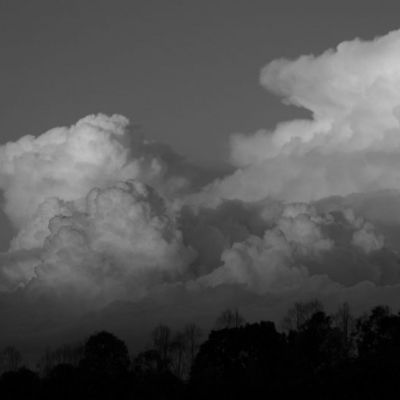

In [19]:
test_img11=ImageOps.grayscale(test_img1)

test_img11

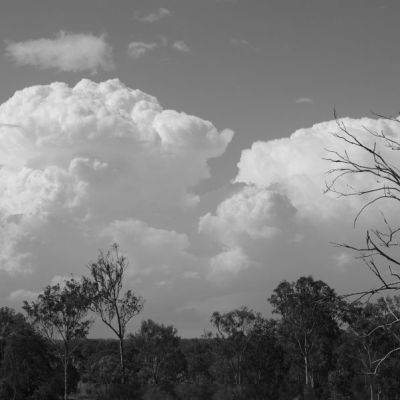

In [20]:
test_img21=ImageOps.grayscale(test_img2)

test_img21

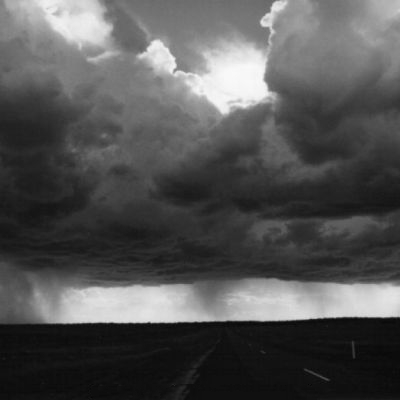

In [22]:
test_img31=ImageOps.grayscale(test_img3)

test_img31

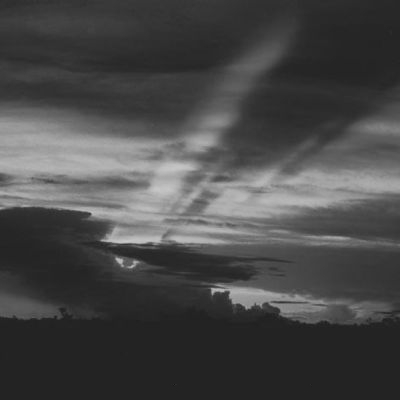

In [24]:
test_img41=ImageOps.grayscale(test_img4)

test_img41

array([[46, 47, 48, ..., 40, 40, 40],
       [47, 48, 48, ..., 40, 40, 40],
       [48, 49, 49, ..., 40, 40, 40],
       ...,
       [35, 35, 35, ..., 35, 35, 35],
       [35, 35, 35, ..., 35, 35, 35],
       [35, 35, 35, ..., 35, 35, 35]], dtype=uint8)
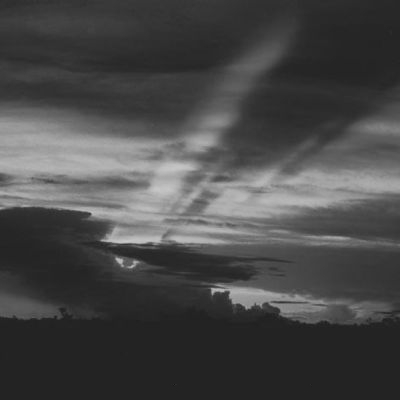

In [27]:
np.asarray(test_img41)

In [29]:
np.average(np.asarray(test_img41))

72.18526875

In [36]:
np.max(np.asarray(test_img41))

202

In [41]:
test_img43 = np.asarray(test_img41) / np.max(np.asarray(test_img41))

In [43]:
test_img43

array([[     58.069,      59.332,      60.594, ...,      50.495,      50.495,      50.495],
       [     59.332,      60.594,      60.594, ...,      50.495,      50.495,      50.495],
       [     60.594,      61.856,      61.856, ...,      50.495,      50.495,      50.495],
       ...,
       [     44.183,      44.183,      44.183, ...,      44.183,      44.183,      44.183],
       [     44.183,      44.183,      44.183, ...,      44.183,      44.183,      44.183],
       [     44.183,      44.183,      44.183, ...,      44.183,      44.183,      44.183]])

In [42]:
Image.fromarray(test_img43)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=400x400>

In [39]:
Image.fromarray(test_img43)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=400x400>

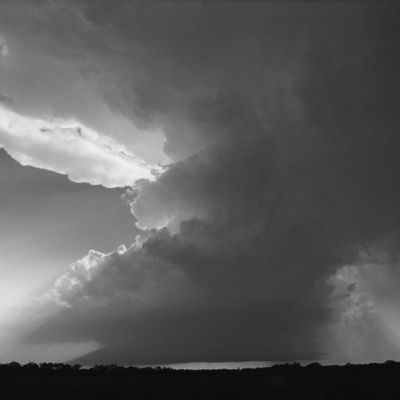

In [17]:
test_img5 = Image.open("/content/greyscale_CCSN/greyscale_CCSN/train/Cb/82.png")

test_img5

In [18]:
np.mean(np.asarray(test_img5))

91.27368125

In [20]:
test_img51 = np.maximum(np.asarray(test_img5) - np.mean(np.asarray(test_img5)), 0)

Image.fromarray(test_img51)
# test_img42

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=400x400>

# Model loading & fine-tuning

In [ ]:
model = YOLO('yolov8s-cls.pt')

100%|██████████| 12.2M/12.2M [00:00<00:00, 50.3MB/s]


In [ ]:
model.train(data=parsed_data_path, epochs=10, patience=10, imgsz=400, save=True, save_period=5, verbose=True, seed=42, val=True)

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/prepared_dataset, epochs=10, time=None, patience=10, batch=16, imgsz=400, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 6.23M/6.23M [00:00<00:00, 147MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]


train: Scanning /content/prepared_dataset/train... 2300 images, 0 corrupt: 100%|██████████| 2300/2300 [00:00<00:00, 3287.06it/s]


train: New cache created: /content/prepared_dataset/train.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 2523.80it/s]

val: New cache created: /content/prepared_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/classify/train8
Starting training for 10 epochs...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


       1/10      1.27G      2.461         16        416:   5%|▍         | 7/144 [00:03<00:44,  3.05it/s]

       1/10      1.27G      2.478         16        416:   6%|▋         | 9/144 [00:04<00:56,  2.37it/s]
100%|██████████| 755k/755k [00:00<00:00, 34.6MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all      0.376      0.838



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 15.60it/s]

                   all      0.444      0.872



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 19.45it/s]

                   all      0.436      0.897



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]

                   all      0.496      0.923



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 13.28it/s]

                   all      0.479      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 18.16it/s]

                   all      0.513      0.915



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 19.81it/s]

                   all      0.573       0.88



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 19.98it/s]

                   all      0.556      0.889



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 20.51it/s]

                   all       0.59      0.906



      Epoch    GPU_mem       loss  Instances       Size


      10/10      1.28G     0.9917         12        416: 100%|██████████| 144/144 [00:47<00:00,  3.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 20.65it/s]

                   all      0.547      0.897



10 epochs completed in 0.140 hours.
Optimizer stripped from runs/classify/train8/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train8/weights/best.pt, 10.3MB

Validating runs/classify/train8/weights/best.pt...
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5089291 parameters, 0 gradients, 12.5 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.26it/s]


                   all       0.59      0.906
Speed: 0.6ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train8
Results saved to runs/classify/train8


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff653c29000>
curves: []
curves_results: []
fitness: 0.7478632628917694
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5897436141967773, 'metrics/accuracy_top5': 0.9059829115867615, 'fitness': 0.7478632628917694}
save_dir: PosixPath('runs/classify/train8')
speed: {'preprocess': 0.6365388886541383, 'inference': 1.3638011410705044, 'loss': 0.0007295200967381143, 'postprocess': 0.0005338945959368323}
task: 'classify'
top1: 0.5897436141967773
top5: 0.9059829115867615

In [ ]:
print(model.val())

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5089291 parameters, 0 gradients, 12.5 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all       0.59      0.906
Speed: 0.3ms preprocess, 5.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/classify/train82


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff5f3a1a4a0>
curves: []
curves_results: []
fitness: 0.7478632628917694
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5897436141967773, 'metrics/accuracy_top5': 0.9059829115867615, 'fitness': 0.7478632628917694}
save_dir: PosixPath('runs/classify/train82')
speed: {'preprocess': 0.32109684414333767, 'inference': 5.842856871776092, 'loss': 0.0011513375828408787, 'postprocess': 0.10473096472585303}
task: 'classify'
top1: 0.5897436141967773
top5: 0.9059829115867615


Now let's try more epochs

In [ ]:
model2 = YOLO('yolov8s-cls.pt')

In [ ]:
model2.train(data=parsed_data_path, epochs=15, patience=10, imgsz=400, save=True, save_period=5, verbose=True, seed=42, val=True)

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/prepared_dataset, epochs=15, time=None, patience=10, batch=16, imgsz=400, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /content/prepared_dataset/train... 2300 images, 0 corrupt: 100%|██████████| 2300/2300 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/classify/train9
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 14.64it/s]

                   all      0.427      0.897



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 22.08it/s]

                   all       0.47      0.872



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 14.84it/s]

                   all       0.47      0.889



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]

                   all      0.487      0.889



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 19.17it/s]

                   all      0.504      0.906



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s]

                   all      0.513      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 21.12it/s]

                   all      0.573      0.889



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]

                   all      0.547      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 20.90it/s]

                   all       0.53      0.923



      Epoch    GPU_mem       loss  Instances       Size


      10/15      1.38G      1.004         12        416: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 13.14it/s]

                   all      0.547      0.923



      Epoch    GPU_mem       loss  Instances       Size


      11/15      1.38G     0.9285         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 25.68it/s]

                   all      0.504      0.915



      Epoch    GPU_mem       loss  Instances       Size


      12/15      1.38G     0.8882         12        416: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]

                   all       0.53      0.915



      Epoch    GPU_mem       loss  Instances       Size


      13/15      1.38G     0.8384         12        416: 100%|██████████| 144/144 [00:51<00:00,  2.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s]

                   all      0.538      0.923



      Epoch    GPU_mem       loss  Instances       Size


      14/15      1.38G       0.81         12        416: 100%|██████████| 144/144 [00:47<00:00,  3.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s]

                   all       0.53      0.932



      Epoch    GPU_mem       loss  Instances       Size


      15/15      1.38G     0.7862         12        416: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 17.83it/s]

                   all       0.53      0.932



15 epochs completed in 0.227 hours.
Optimizer stripped from runs/classify/train9/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train9/weights/best.pt, 10.3MB

Validating runs/classify/train9/weights/best.pt...
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5089291 parameters, 0 gradients, 12.5 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 13.38it/s]


                   all      0.547      0.923
Speed: 0.4ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train9
Results saved to runs/classify/train9


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff5f395f3a0>
curves: []
curves_results: []
fitness: 0.7350427508354187
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5470085740089417, 'metrics/accuracy_top5': 0.9230769276618958, 'fitness': 0.7350427508354187}
save_dir: PosixPath('runs/classify/train9')
speed: {'preprocess': 0.4063182406955295, 'inference': 1.3541237920777411, 'loss': 0.0012043194893078925, 'postprocess': 0.0008925413474058494}
task: 'classify'
top1: 0.5470085740089417
top5: 0.9230769276618958

In [ ]:
print(model2.val())

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5089291 parameters, 0 gradients, 12.5 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all      0.547      0.923
Speed: 0.6ms preprocess, 4.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train92
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff5f3b56aa0>
curves: []
curves_results: []
fitness: 0.7350427508354187
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5470085740089417, 'metrics/accuracy_top5': 0.9230769276618958, 'fitness': 0.7350427508354187}
save_dir: PosixPath('runs/classify/train92')
speed: {'preprocess': 0.602145480294513, 'inference': 4.1184078933846235, 'loss': 0.0010861290825737847, 'postprocess': 0.001163564176640959}
task: 'classify'
top1: 0.5470085740089417
top5: 0.9230769276618958


The results are still not great, so let's try with the bigger model

In [ ]:
model_md = YOLO('yolov8m-cls.pt')

100%|██████████| 32.7M/32.7M [00:00<00:00, 312MB/s]


In [ ]:
model_md.train(data=parsed_data_path, epochs=15, patience=10, imgsz=400, save=True, save_period=5, verbose=True, seed=42, val=True)

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/prepared_dataset, epochs=15, time=None, patience=10, batch=16, imgsz=400, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 6.23M/6.23M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]


train: Scanning /content/prepared_dataset/train... 2300 images, 0 corrupt: 100%|██████████| 2300/2300 [00:00<00:00, 3268.50it/s]


train: New cache created: /content/prepared_dataset/train.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 3163.68it/s]

val: New cache created: /content/prepared_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/15      2.18G       2.42         16        416:   3%|▎         | 5/144 [00:02<00:57,  2.41it/s]

       1/15      2.18G      2.418         16        416:   7%|▋         | 10/144 [00:04<00:47,  2.80it/s]
100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all      0.479      0.897



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

                   all      0.521      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]

                   all      0.496      0.846



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.95it/s]

                   all      0.504      0.949



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.12it/s]

                   all      0.581      0.932



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]

                   all      0.598       0.94



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.88it/s]

                   all      0.598      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]

                   all      0.624      0.966



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.91it/s]

                   all      0.632      0.949



      Epoch    GPU_mem       loss  Instances       Size


      10/15      2.14G     0.9148         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]

                   all      0.598      0.966



      Epoch    GPU_mem       loss  Instances       Size


      11/15      2.14G     0.7898         12        416: 100%|██████████| 144/144 [00:48<00:00,  2.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]

                   all       0.59      0.957



      Epoch    GPU_mem       loss  Instances       Size


      12/15      2.14G     0.7403         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.65it/s]

                   all      0.615      0.974



      Epoch    GPU_mem       loss  Instances       Size


      13/15      2.14G     0.6743         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]

                   all       0.59      0.957



      Epoch    GPU_mem       loss  Instances       Size


      14/15      2.14G     0.6364         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]

                   all      0.615      0.966



      Epoch    GPU_mem       loss  Instances       Size


      15/15      2.14G     0.5879         12        416: 100%|██████████| 144/144 [00:49<00:00,  2.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.38it/s]

                   all       0.59      0.974



15 epochs completed in 0.220 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/train/weights/best.pt, 31.7MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15776747 parameters, 0 gradients, 41.6 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


                   all      0.615      0.974
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf244fcfd00>
curves: []
curves_results: []
fitness: 0.7948718070983887
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6153846383094788, 'metrics/accuracy_top5': 0.9743589758872986, 'fitness': 0.7948718070983887}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.29269854227701825, 'inference': 3.7373131156986594, 'loss': 0.0008538238003722624, 'postprocess': 0.00046868609566973825}
task: 'classify'
top1: 0.6153846383094788
top5: 0.9743589758872986

In [ ]:
model_lg = YOLO('yolov8l-cls.pt')

100%|██████████| 71.7M/71.7M [00:00<00:00, 280MB/s]


In [ ]:
model_lg.train(data=parsed_data_path, epochs=15, patience=10, imgsz=400, save=True, save_period=5, verbose=True, seed=42, val=True)

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=/content/prepared_dataset, epochs=15, time=None, patience=10, batch=16, imgsz=400, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /content/prepared_dataset/train... 2300 images, 0 corrupt: 100%|██████████| 2300/2300 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/prepared_dataset/val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all      0.462      0.897



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all      0.444      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

                   all      0.538      0.906



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all      0.479      0.915



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

                   all      0.547      0.974



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all      0.632      0.932



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]

                   all      0.615      0.983



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

                   all      0.556      0.932



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]

                   all      0.581       0.94



      Epoch    GPU_mem       loss  Instances       Size


      10/15       3.9G     0.8512         12        416: 100%|██████████| 144/144 [00:54<00:00,  2.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all      0.547      0.932



      Epoch    GPU_mem       loss  Instances       Size


      11/15       3.9G     0.7142         12        416: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all      0.615      0.949



      Epoch    GPU_mem       loss  Instances       Size


      12/15       3.9G     0.6631         12        416: 100%|██████████| 144/144 [00:55<00:00,  2.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all      0.615      0.983



      Epoch    GPU_mem       loss  Instances       Size


      13/15       3.9G     0.5703         12        416: 100%|██████████| 144/144 [01:00<00:00,  2.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

                   all      0.581      0.923



      Epoch    GPU_mem       loss  Instances       Size


      14/15       3.9G     0.5316         12        416: 100%|██████████| 144/144 [00:59<00:00,  2.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

                   all      0.598       0.94



      Epoch    GPU_mem       loss  Instances       Size


      15/15       3.9G     0.4877         12        416: 100%|██████████| 144/144 [00:57<00:00,  2.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

                   all      0.564       0.94



15 epochs completed in 0.263 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 72.6MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 72.6MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8l-cls summary (fused): 133 layers, 36198667 parameters, 0 gradients, 98.7 GFLOPs
train: /content/prepared_dataset/train... found 2300 images in 11 classes ✅ 
val: /content/prepared_dataset/val... found 117 images in 11 classes ✅ 
test: /content/prepared_dataset/test... found 126 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


                   all      0.615      0.983
Speed: 0.3ms preprocess, 4.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf1ef2a6470>
curves: []
curves_results: []
fitness: 0.7991453111171722
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6153846383094788, 'metrics/accuracy_top5': 0.9829059839248657, 'fitness': 0.7991453111171722}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.2812422238863431, 'inference': 4.881956638433994, 'loss': 0.0009801652696397568, 'postprocess': 0.0009108812381059696}
task: 'classify'
top1: 0.6153846383094788
top5: 0.9829059839248657

### Training on greyscale CCSN

In [12]:
!unzip greyscale_CCSN.zip -d /content/greyscale_CCSN

Archive:  greyscale_CCSN.zip
   creating: /content/greyscale_CCSN/greyscale_CCSN/test/
   creating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/0.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/1.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/10.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/2.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/3.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/4.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/5.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/6.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/7.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/8.png  
  inflating: /content/greyscale_CCSN/greyscale_CCSN/test/Ac/9.png  
   creating: /content/greyscale_CCSN/greyscale_CCSN/test/As/
  inflating: /content/greyscale_CCSN/greys

In [11]:
model_md = YOLO('yolov8m-cls.pt')

100%|██████████| 32.7M/32.7M [00:00<00:00, 236MB/s]


In [21]:
model_md.train(data="/content/greyscale_CCSN/greyscale_CCSN", epochs=15, patience=10, imgsz=400, save=True, save_period=5, verbose=True, seed=42, val=True)

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/greyscale_CCSN/greyscale_CCSN, epochs=15, time=None, patience=10, batch=16, imgsz=400, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

100%|██████████| 6.23M/6.23M [00:00<00:00, 84.2MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]


train: Scanning /content/greyscale_CCSN/greyscale_CCSN/train... 2248 images, 0 corrupt: 100%|██████████| 2248/2248 [00:00<00:00, 4682.53it/s]

train: New cache created: /content/greyscale_CCSN/greyscale_CCSN/train.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/greyscale_CCSN/greyscale_CCSN/val... 114 images, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 3349.14it/s]

val: New cache created: /content/greyscale_CCSN/greyscale_CCSN/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/15       2.2G      2.422         16        416:   4%|▎         | 5/141 [00:02<00:59,  2.28it/s]

       1/15       2.2G      2.433         16        416:   6%|▌         | 8/141 [00:04<01:15,  1.76it/s]
100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all      0.412       0.86



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.28it/s]

                   all      0.491      0.904



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.98it/s]

                   all      0.491      0.904



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

                   all      0.553       0.93



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]

                   all      0.596      0.921



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

                   all      0.579      0.912



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]

                   all       0.57      0.947



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.68it/s]

                   all      0.614      0.939



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.13it/s]

                   all      0.561      0.956



      Epoch    GPU_mem       loss  Instances       Size


      10/15      2.23G     0.9474          8        416: 100%|██████████| 141/141 [00:44<00:00,  3.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.64it/s]

                   all      0.605       0.93



      Epoch    GPU_mem       loss  Instances       Size


      11/15      2.23G     0.8837          8        416: 100%|██████████| 141/141 [00:44<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]

                   all      0.605      0.947



      Epoch    GPU_mem       loss  Instances       Size


      12/15      2.22G     0.8169          8        416: 100%|██████████| 141/141 [00:43<00:00,  3.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 11.12it/s]

                   all      0.614      0.939



      Epoch    GPU_mem       loss  Instances       Size


      13/15      2.16G     0.7378          8        416: 100%|██████████| 141/141 [00:47<00:00,  2.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.94it/s]

                   all      0.605      0.939



      Epoch    GPU_mem       loss  Instances       Size


      14/15      2.23G      0.665          8        416: 100%|██████████| 141/141 [00:43<00:00,  3.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]

                   all      0.596      0.947



      Epoch    GPU_mem       loss  Instances       Size


      15/15      2.22G     0.6181          8        416: 100%|██████████| 141/141 [00:43<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.51it/s]

                   all      0.596      0.947



15 epochs completed in 0.207 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/train/weights/best.pt, 31.7MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15776747 parameters, 0 gradients, 41.6 GFLOPs
train: /content/greyscale_CCSN/greyscale_CCSN/train... found 2248 images in 11 classes ✅ 
val: /content/greyscale_CCSN/greyscale_CCSN/val... found 114 images in 11 classes ✅ 
test: /content/greyscale_CCSN/greyscale_CCSN/test... found 125 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


                   all      0.605      0.939
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1334cd21d0>
curves: []
curves_results: []
fitness: 0.7719298303127289
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6052631735801697, 'metrics/accuracy_top5': 0.9385964870452881, 'fitness': 0.7719298303127289}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.4433916326154742, 'inference': 2.4612410026684146, 'loss': 0.000587680883574904, 'postprocess': 0.0005123908059638842}
task: 'classify'
top1: 0.6052631735801697
top5: 0.9385964870452881

In [22]:
export = model_md.export()

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8m-cls summary (fused): 103 layers, 15776747 parameters, 0 gradients, 41.6 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 11) (30.2 MB)

TorchScript: starting export with torch 2.3.0+cu121...
TorchScript: export success ✅ 3.9s, saved as 'runs/classify/train/weights/best.torchscript' (60.4 MB)

Export complete (6.6s)
Results saved to /content/runs/classify/train/weights
Predict:         yolo predict task=classify model=runs/classify/train/weights/best.torchscript imgsz=416  
Validate:        yolo val task=classify model=runs/classify/train/weights/best.torchscript imgsz=416 data=/content/greyscale_CCSN/greyscale_CCSN  
Visualize:       https://netron.app


# Saving model

In [ ]:
export = model.export()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/classify/train8/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 11) (9.8 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 0.9s, saved as 'runs/classify/train8/weights/best.torchscript' (19.6 MB)

Export complete (2.5s)
Results saved to /content/runs/classify/train8/weights
Predict:         yolo predict task=classify model=runs/classify/train8/weights/best.torchscript imgsz=416  
Validate:        yolo val task=classify model=runs/classify/train8/weights/best.torchscript imgsz=416 data=/content/prepared_dataset  
Visualize:       https://netron.app


In [ ]:
export = model_md.export()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8m-cls summary (fused): 103 layers, 15776747 parameters, 0 gradients, 41.6 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 11) (30.2 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 1.9s, saved as 'runs/classify/train/weights/best.torchscript' (60.4 MB)

Export complete (4.2s)
Results saved to /content/runs/classify/train/weights
Predict:         yolo predict task=classify model=runs/classify/train/weights/best.torchscript imgsz=416  
Validate:        yolo val task=classify model=runs/classify/train/weights/best.torchscript imgsz=416 data=/content/prepared_dataset  
Visualize:       https://netron.app


In [ ]:
export = model_lg.export()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8l-cls summary (fused): 133 layers, 36198667 parameters, 0 gradients, 98.7 GFLOPs

PyTorch: starting from 'runs/classify/train2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 11) (69.2 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 3.5s, saved as 'runs/classify/train2/weights/best.torchscript' (138.4 MB)

Export complete (6.5s)
Results saved to /content/runs/classify/train2/weights
Predict:         yolo predict task=classify model=runs/classify/train2/weights/best.torchscript imgsz=416  
Validate:        yolo val task=classify model=runs/classify/train2/weights/best.torchscript imgsz=416 data=/content/prepared_dataset  
Visualize:       https://netron.app


# Using model for prediction

In [ ]:
test_model = YOLO("/content/best.pt")

In [ ]:
results = test_model("/content/test_cloud.jpg")


image 1/1 /content/test_cloud.jpg: 416x416 Cu 0.95, Ac 0.03, Cc 0.01, Cb 0.01, St 0.00, 24.7ms
Speed: 147.8ms preprocess, 24.7ms inference, 0.1ms postprocess per image at shape (1, 3, 416, 416)


In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'Ac', 1: 'As', 2: 'Cb', 3: 'Cc', 4: 'Ci', 5: 'Cs', 6: 'Ct', 7: 'Cu', 8: 'Ns', 9: 'Sc', 10: 'St'}
 obb: None
 orig_img: array([[[158,  74,  56],
         [156,  74,  56],
         [156,  74,  56],
         ...,
         [159,  83,  61],
         [158,  82,  60],
         [158,  82,  60]],
 
        [[156,  74,  56],
         [156,  74,  56],
         [155,  73,  55],
         ...,
         [160,  81,  60],
         [160,  81,  60],
         [160,  81,  60]],
 
        [[155,  73,  55],
         [155,  73,  55],
         [155,  73,  55],
         ...,
         [160,  81,  60],
         [160,  81,  60],
         [160,  81,  60]],
 
        ...,
 
        [[193, 126, 101],
         [193, 126, 101],
         [194, 127, 102],
         ...,
         [193, 126, 101],
         [193, 126, 101],
         [193, 126, 101]],
 
        [[193, 126, 101],
         [193, 126, 101],
      

In [ ]:
classes_map = results[0].names
# print(classes_map)
print(classes_map[results[0].probs.top1])

Cu


# Model in PyTorch

Attempt at recreating the CNN from the [paper which introduces CCSN](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018GL077787).

## Setup

In [5]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import gc

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def imshow(img, label: str):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.show()

## Mapping the data

In [15]:
!unzip /content/no_night_CCSN_no_contrail.zip -d /content/ccsn

Archive:  /content/no_night_CCSN_no_contrail.zip
   creating: /content/ccsn/no_night_CCSN_no_contrail/Ac/
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N001.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N002.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N003.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N004.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N005.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N006.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N007.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N008.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N009.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N010.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N011.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/Ac/Ac-N012.jpg  
  inflating: /content/ccsn/no_night_CCSN_no_contrail/A

In [9]:
classes_no_contrail = ["Ci", "Cs", "Cc", "Ac", "As", "Cu", "Cb", "Ns", "Sc", "St"]

In [27]:
batch_size=16

In [43]:
def split_data_for_pt(dataset_dir: str) -> dict[dict[str, list[str]]]:
  splits = {"train": {}, "test": {}}
  sets = {"train": 0.95, "test": 0.05}

  transform = transforms.Compose([transforms.Resize(size=(400,400)), transforms.ToTensor()]) #version for 400x400
  # transform = transforms.Compose([transforms.Resize(size=(256,256)), transforms.ToTensor()]) #version for 256x256

  for _cls in classes_no_contrail:
    splits["train"].update({_cls: []})
    splits["test"].update({_cls: []})

    class_path = os.path.join(dataset_dir, _cls)
    images = [transform(ImageOps.grayscale(Image.open(join(class_path, f)))) for f in listdir(class_path) if isfile(join(class_path, f))]
    sets_nums = {k: round(item * len(images)) for k, item in sets.items()}

    nums_sum = sum(list(sets_nums.values()))

    print(f"Images in class {_cls} are distributed as follows: train={sets_nums['train']}, test={sets_nums['test']}, total={nums_sum}. There are {len(images)} images. Any excess images will de added to the test subset")
    print("-"*80)

    for idx, img in enumerate(images):
      if idx <= sets_nums["train"]:
        splits["train"][_cls].append(img)

      else:
        splits["test"][_cls].append(img)

  return splits

In [44]:
splits = split_data_for_pt("/content/ccsn/no_night_CCSN_no_contrail")


Images in class Ci are distributed as follows: train=132, test=7, total=139. There are 139 images. Any excess images will de added to the test subset
--------------------------------------------------------------------------------
Images in class Cs are distributed as follows: train=267, test=14, total=281. There are 281 images. Any excess images will de added to the test subset
--------------------------------------------------------------------------------
Images in class Cc are distributed as follows: train=243, test=13, total=256. There are 256 images. Any excess images will de added to the test subset
--------------------------------------------------------------------------------
Images in class Ac are distributed as follows: train=201, test=11, total=212. There are 212 images. Any excess images will de added to the test subset
--------------------------------------------------------------------------------
Images in class As are distributed as follows: train=170, test=9, total=1

In [12]:
def map_splits(split:dict[str, list[str]]) -> list[tuple]:
  mapped = []

  for _cls, images in split.items():
    cls_index = classes_no_contrail.index(_cls)
    for image in images:
      mapped.append([image, cls_index])

  return mapped

In [45]:
trainloader = torch.utils.data.DataLoader(
    map_splits(splits["train"]), batch_size=batch_size, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    map_splits(splits["test"]), batch_size=batch_size, shuffle=True
)

In [50]:
splits = None
gc.collect()

8

## Creating the CNN

In [51]:
class CloudNet400(nn.Module):
    def __init__(self, with_greyscale:bool=False):
        super().__init__()

        self.initial_in = 3

        if with_greyscale:
          self.initial_in = 1

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=self.initial_in, out_channels=96,kernel_size=(12,12), stride=4),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(in_channels=96, out_channels=256,kernel_size=(5,5), padding=2),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(3,3), stride=2),

            nn.Conv2d(in_channels=256, out_channels=384,kernel_size=(3,3), padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=(3,3), padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Flatten(),

            nn.Linear(256*12*12, 256*12*6),
            nn.ReLU(),

            nn.Dropout(p=0.5),

            nn.Linear(256*12*6, len(classes_no_contrail)),
            nn.Softmax(dim=0)
            )


    def forward(self, x):
        return self.cnn(x)

In [52]:
class CloudNet256(nn.Module):
    def __init__(self, with_greyscale:bool=False):
        super().__init__()

        self.initial_in = 3

        if with_greyscale:
          self.initial_in = 1

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=self.initial_in, out_channels=96,kernel_size=(12,12), stride=4),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(in_channels=96, out_channels=256,kernel_size=(5,5), padding=2),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(3,3), stride=2),

            nn.Conv2d(in_channels=256, out_channels=384,kernel_size=(3,3), padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=(3,3), padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(3,3), stride=2),

            nn.Flatten(),

            nn.Linear(256*7*7, 128*7*7),
            nn.ReLU(),

            nn.Dropout(p=0.5),

            nn.Linear(128*7*7, len(classes_no_contrail)),
            nn.Softmax(dim=0)
            )


    def forward(self, x):
        return self.cnn(x)

## Training

In [53]:
model = CloudNet400(with_greyscale=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

no_epochs = 25

In [54]:
model.train()

for epoch in range(no_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        y_hat = model(inputs)

        # loss calculation
        loss = criterion(y_hat, labels)

        # backpropagation
        loss.backward()

        # optimization
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

    gc.collect()

print("Finished Training")

Finished Training


## Empirical Testing

In [55]:
model.eval()

CloudNet400(
  (cnn): Sequential(
    (0): Conv2d(1, 96, kernel_size=(12, 12), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=36864, out_features=18432, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=18432, out_features=10, bias=True)
    (16): Softmax(dim=0)
  )
)

In [56]:
dataiter = iter(testloader)
images_examples, labels_examples = next(dataiter)

len(images_examples)

16

In [57]:
outputs = model(images_examples.to(device))
_, predicted = torch.max(outputs, 1)

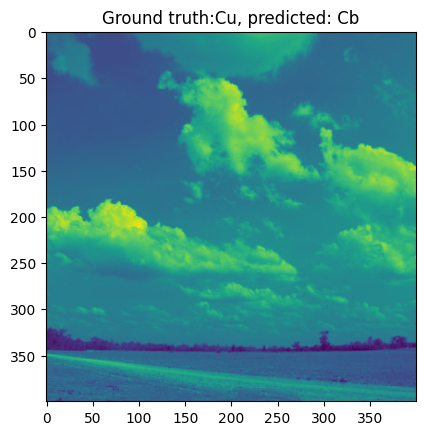

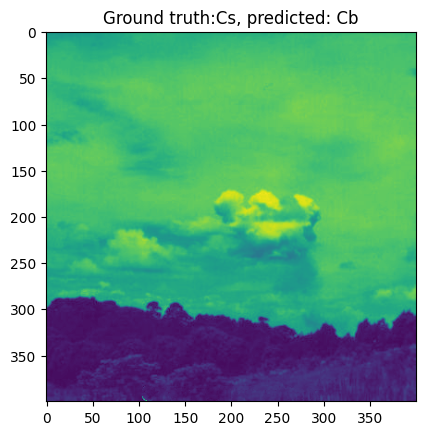

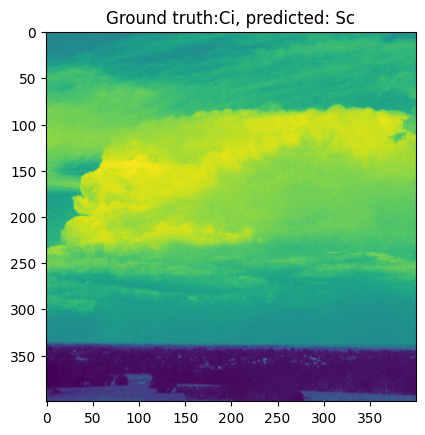

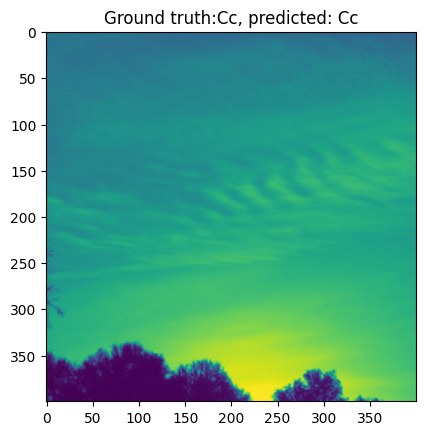

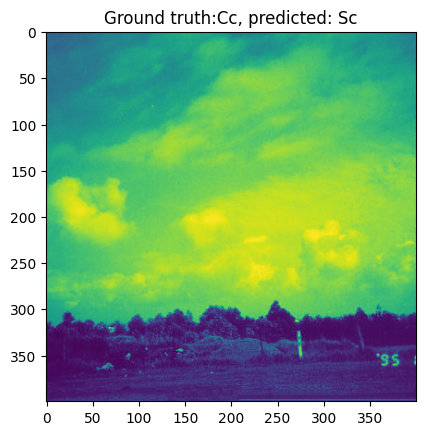

In [58]:
for i in range(5):
  imshow(images_examples[i], f"Ground truth:{classes_no_contrail[labels_examples[i]]}, predicted: {classes_no_contrail[predicted[i]]}")

## Evaluation

In [59]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct // total} %")

Accuracy of the network on the 105 test images: 16 %


## Saving and reloading the model

In [62]:
save_path = "/content/model.pt"

In [64]:
torch.save(model.state_dict(), save_path)

In [ ]:
model = CloudNet400(with_greyscale=True)
model.load_state_dict(torch.load(save_path))
model.eval()